# Máquinas de Soporte Vectorial (SVM) e Histograma de Gradientes Orientados (HOG)

En este tutorial estudiaremos cómo implementar una máquina de soporte vectorial desde cero y empleando una clase de la librería de `sklearn`. Posteriormente, estudiaremos cómo podemos representar la forma de una imagen o ventana a través de su histograma de gradientes orientados.

## Máquinas de Soporte Vectorial (SVM)

Las Máquinas de Soporte Vectorial son un método de clasificación supervisada para elementos que se pueden representar como puntos en un espacion de dimension superior. El fundamento de este método yace en encontrar una superficie que separe a todos los elementos de una clase del resto de elementos de la mejor forma posible. Por ejemplo, al usar un kernel de intersección lineal, se busca el hiperplano que separe de mejor forma a una clase de las demás. A continuación, se presenta la formulación matemática y la visualización de una máquina de soporte vectorial que separa a dos clases en un espacio de 2 dimensiones:

<div>
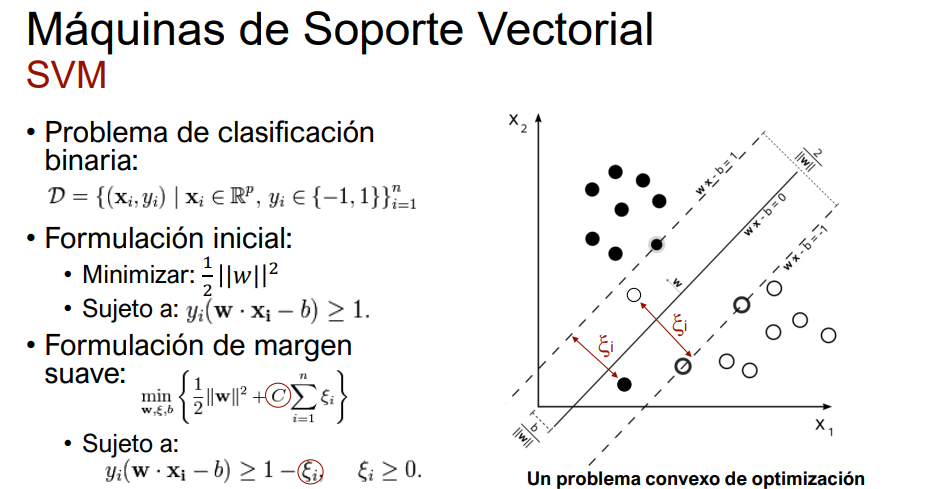
</div>

Como se ve en la imagen, en este caso se busca obtener los parámetros ($\mathbf{w}$ y $b$) de la linea que separe de mejor forma las dos clases de puntos. ¿Qué significa *separar de la mejor forma*? Idealmente, esto implica dos cosas:

1. Que el margen entre el dato bien clasificado más cercano y la superficie de separación sea la más grande posible.
1. Que la distancia entre las márgenes de clasificación y los datos mal clasificados sea la menor posible. 

Para considerar estos dos objetivos, se ha formulado el problema de encontrar la superficie que *separe las clases de la mejor forma* como el siguiente problema de optimización:

\begin{equation}
\min_{\mathbf{w}, \xi, b} \left( \frac{1}{2} ||\mathbf{w}||^2 + C \sum^n_{i=1}  \xi_i \right)
\end{equation}

Donde $||\mathbf{w}||$ es la norma del vector normal que caracteriza el hiperplano y $\xi_i$ es la distancia entre el margen de clasificación y cada punto clasificado incorrectamente. Minimizar la norma (el primer término) resulta en aumentar el márgen, y minimizar la suma de los $\xi_i$ (el segundo término) disminuye la cantidad de puntos mal clasificados. Note que enfocarse en uno de los objetivos puede tener un efecto negativo con respecto al otro, por lo que la constante $C$ es un parámetro empleado para balancear la importancia asignada a cada término.

Una manera sencilla de formular la tarea de clasificación es asignarle a todos los puntos a un lado de la superficie una etiqueta de `-1` y a los del otro lado la etiqueta de `1`. Podemos definir la confianza del método como la distancia (positiva en dirección del vector normal) entre la superficie y el punto, pues nos indica qué tan cerca está de la frontera en la que se le asignaría otra etiqueta. Partiendo de esta definición, podemos asignarle a cada punto una etiqueta mediante el signo de su confianza. Esto se puede resumir en las siguientes ecuaciones:

\begin{equation}
C(x) = \mathbf{w} \cdot x - b \\
y = sign(C(x))
\end{equation}

donde $C(x)$ es la confianza asociada al punto $x$, y $y$ es su etiqueta predicha.

Para estudiar nuestra propia implementación de un SVM crearemos un conjunto de datos semejante al de la imagen anterior, compuesto por dos clases de puntos en un espacio de dos dimensiones:

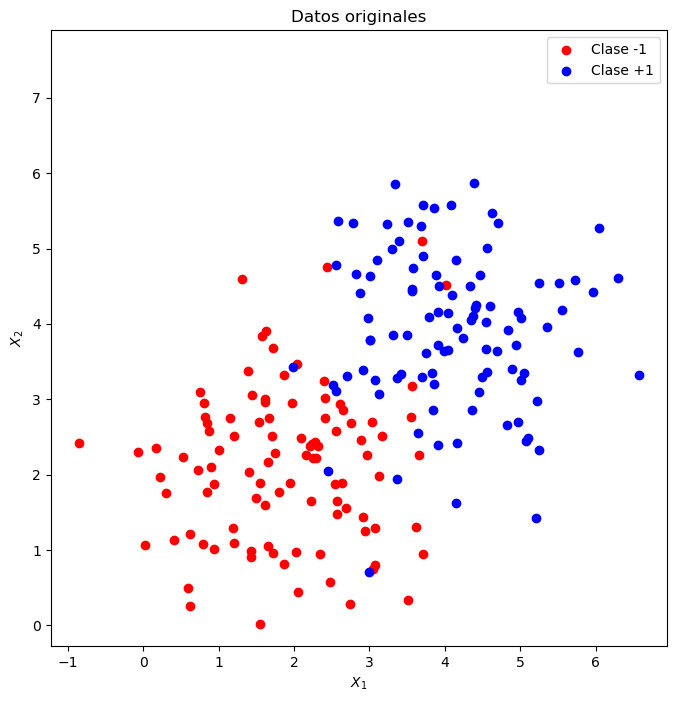

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(21)
X_1 = np.random.multivariate_normal(mean=[2,2], cov=[[1,0],[0,1]], size=100)
X_2 = np.random.multivariate_normal(mean=[4,4], cov=[[1,0],[0,1]], size=100)

X = np.vstack([X_1, X_2])

Y = np.array([-1]*X_1.shape[0] + [1]*X_2.shape[0]).reshape(-1,1)

# Visualización
plt.figure(figsize=(15,8))
plt.scatter(X_1[:, 0], X_1[:, 1], color="r", label="Clase -1")
plt.scatter(X_2[:, 0], X_2[:, 1], color="b", label="Clase +1")
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.title("Datos originales")
plt.axis('square')
plt.legend()
plt.show()

El primer paso para implementar un SVM es definir nuestra función a minimizar, la cual vamos a llamar *función de costo*. Previamente habiamos dicho que esta función es equivalente a:

\begin{equation}
J(\mathbf{w}) = \left( \frac{1}{2} ||\mathbf{w}||^2 + C \sum^n_{i=1}  \xi_i \right)
\end{equation}

Note que podemos utilizar la forma en la que clasificamos cada punto para reescribir la suma sobre los $\xi_i$ de la siguiente forma:

\begin{equation}
J(\mathbf{w}) = \left( \frac{1}{2} ||\mathbf{w}||^2 + C \sum^n_{i=1} \max{(0, 1 - y_i(\mathbf{w} \cdot x_i - b})) \right)
\end{equation}

Entendamos de dónde sale esta expresión. Note que las siguientes afirmaciones son ciertas:
- Si el punto está más allá de los márgenes del hiperplano, la norma de ($\mathbf{w} \cdot x_i - b$) será mayor a 1.
- Si el punto se encuentran del lado correcto, el producto entre $y_i$ y $(\mathbf{w} \cdot x_i - b)$ siempre será positivo.
- Si el punto está bien clasificado y se encuentra más allá del margen de la superficie, se cumple que $\max{(0, 1 - y_i(\mathbf{w} \cdot x_i - b))} = 0.$ 

La última afirmación implica que si el punto está bien clasificado y se encuentra más allá del margen de la superficie su distancia no se cuenta para calcular la función de costo. Esta función solo sumará las distancias de los puntos que fueron mal clasificados, o que se encuentran dentro del márgen del hiperplano. A continuación, implementemos la función de costo:

In [2]:
def cost_function(W, b, C, X, Y):
    # Se calcula (1 - el producto entre la confianza y la etiqueta) para todo el conjunto de entrenamiento
    distances = 1 - Y * (np.dot(X, W) - b)
    # Esto es equivalente a aplicar la función de máximo explicada anteriormente
    distances[distances < 0] = 0
    # Se calcula el costo asociado a las etiquetas mal clasificadas
    xi_cost = C * np.sum(distances)
    # Se calcula el costo asociado a la norma del vector normal
    norm_cost = 0.5 * np.dot(W.T, W)
    # Se calcula el costo total
    cost = norm_cost + xi_cost
    return cost, norm_cost, xi_cost

¿Cómo encontramos el mínimo de la función de costo? Podemos implementar el método de descenso de gradiente estocástico (SGD). Este método consiste en actualizar iterativamente los parámetros del modelo ($\mathbf{w}$ y $b$) desplazando su valor en dirección contraria al gradiente de la función de costo. Esto se puede resumir en las siguientes ecuaciones:
\begin{equation}
\mathbf{w}_k^{n+1} =  \mathbf{w}_k^{n} - \alpha \frac{\partial J}{\partial \mathbf{w}_k} \\
b^{n+1} =  b^{n} - \alpha \frac{\partial J}{\partial b}
\end{equation}

donde $\alpha$ se suele conocer como la tasa de apredizaje y toma un valor arbitrario pequeño. Los índices $n$ y $n+1$ no son exponentes, sino que hacen referencia a los valores de $\mathbf{w}$ y $b$ en dos iteraciones consecutivas. $\mathbf{w}_k$ hace referencia al $k$-ésimo parámetro del hiperplano. Por ejemplo, en el caso de una línea, $k$ solo puede tomar el valor de 1, y $\mathbf{w}_1$ es la pendiente de la línea.

Para actualizar los valores de $\mathbf{w}$ y $b$ necesitamos calcular las derivadas parciales de la función de costo con respecto a estos parámetros. Note que dichas derivadas dependen de si $y_i(\mathbf{w} \cdot x_i - b)$ es mayor que 1, de la siguiente forma:

Si $y_i(\mathbf{w} \cdot x_i - b) \geq 1$:

\begin{equation}
\frac{\partial J}{\partial \mathbf{w}_k} = \mathbf{w}_k \\
\frac{\partial J}{\partial b} = 0
\end{equation}

Si $y_i(\mathbf{w} \cdot x_i - b) < 1$:

\begin{equation}
\frac{\partial J}{\partial \mathbf{w}_k} = \mathbf{w}_k - C y_{i} x_{i} \\
\frac{\partial J}{\partial b} = C y_{i}
\end{equation}

A continuación crearemos las funciones necesarias para nuestra implementación.

Una función que nos retorne estas derivadas parciales con base en los parámetros, una entrada y su respectiva etiqueta:

In [3]:
def get_gradients(W, b, C, X_i, Y_i):
    # Producto entre etiqueta y confianza mayor que 1
    if Y_i * (np.dot(W.T, X_i) - b) > 1:
        dW = W
        db = 0
    # Producto entre etiqueta y confianza menor que 1
    else:
        dW = W - (C * X_i * Y_i)
        db = C * Y_i
    return dW, db     

La función que actualiza los valores de $\mathbf{w}$ y $b$ siguiendo el algoritmo de SGD:

In [4]:
def SGD(alpha, W, b, dW, db):
    W = W - alpha * dW
    b = b - alpha * db
    return W, b

Una función que nos permita visualizar la línea dada por los parámetros $\mathbf{w}$ y $b$ junto con los datos de entrenamiento:

In [5]:
# Función auxiliar que retorna la pendiente y el intercepto de la linea en función del vector normal (W) y b
def Wb_to_mb(W, b):
    slope = -(b/W[1])/(b/W[0])
    intercept = -(b/W[1])
    return slope, intercept


def visualize(W, b, X, Y, n):
    
    plt.figure(figsize=(15,8))
    plt.title("Iteración " + str(n))
    plt.scatter(X_1[:, 0], X_1[:, 1], color="r", label="Clase 1")
    plt.scatter(X_2[:, 0], X_2[:, 1], color="b", label="Clase 2")
    plt.xlabel(r"$X_1$")
    plt.ylabel(r"$X_2$")

    plt.axis('square')
    
    slope, intercept = Wb_to_mb(W, b)
    slope_plus, intercept_plus = Wb_to_mb(W, b + 1)
    slope_minus, intercept_minus = Wb_to_mb(W, b - 1)
    
    x = np.linspace(0,6)
    plt.gca().axline((0,intercept[0]), slope=slope, color="k", label="Hiperplano")
    plt.gca().axline((0,intercept_plus[0]), slope=slope_plus, color="b", linestyle="--", label="Margen +1")
    plt.gca().axline((0,intercept_minus[0]), slope=slope_minus, color="r", linestyle="--", label="Margen -1")

    
    plt.legend()
plt.show()
visualize(np.array([[2],[-1]]), -2, X, Y, 0)

Error in callback <function _draw_all_if_interactive at 0x0000021D6CE99E40> (for post_execute):


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

Ahora juntamos las funciones anteriores para implementar un SVM y visualizaremos cómo varía la línea de separación a medida que avanza el entrenamiento:

C:\Users\eduar\AppData\Local\Temp\ipykernel_23136\3415700883.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,8))


Error in callback <function _draw_all_if_interactive at 0x0000021D6CE99E40> (for post_execute):


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 1500x800 with 1 Axes>

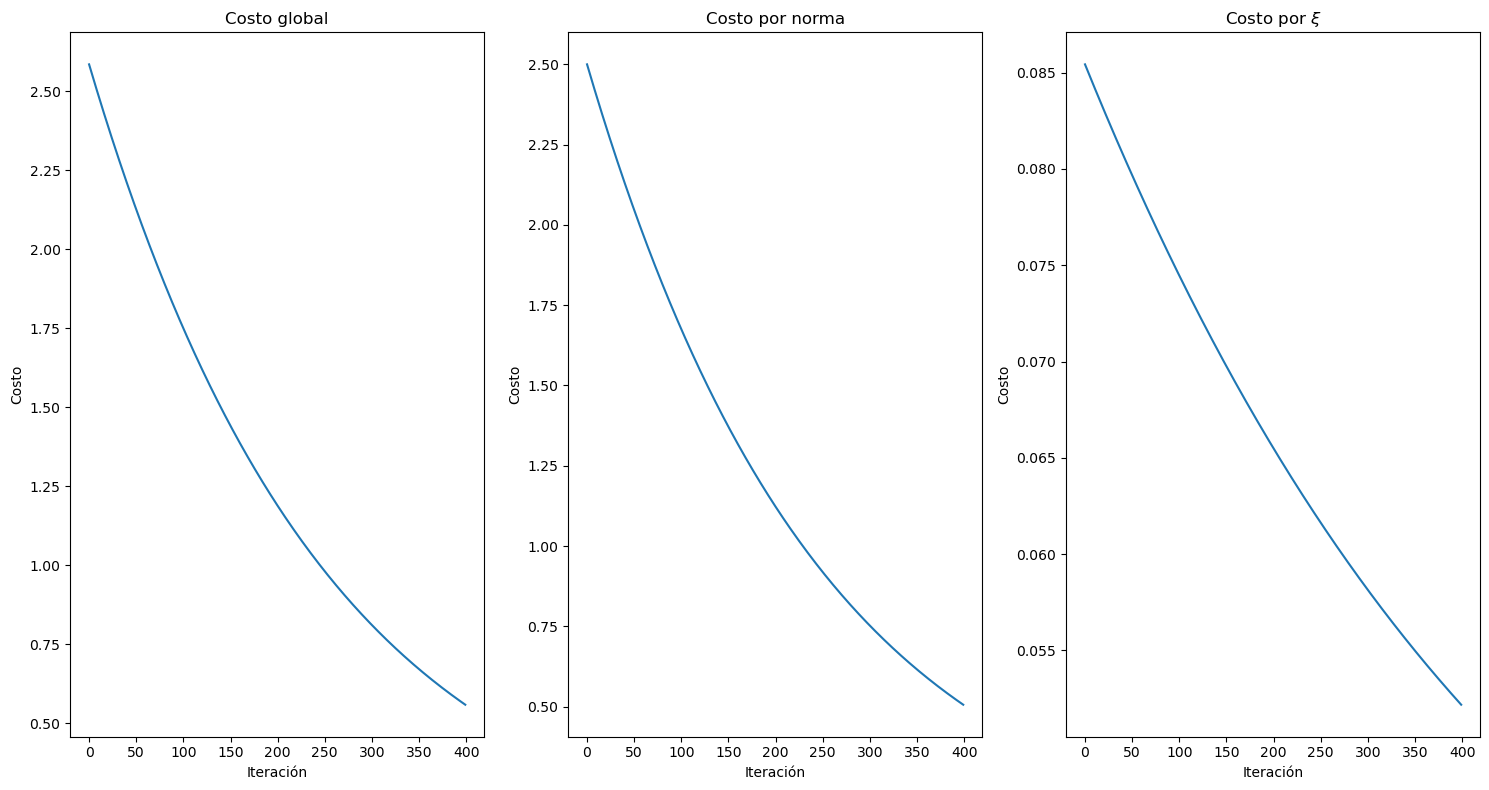

In [6]:
def SVM(X, Y, C, alpha, n_iter):
    
    # Inicialización de W y b. Podría hacerse de forma aleatoria. Se eligen estos parámetros para garantizar que el
    # algoritmo converja
    W, b = np.array([[-2],[-1]]), 4
    
    # Listas en las que se almacenará el valor de la función de costo, y de cada uno de sus términos, para cada iteración
    costs = []
    norm_costs = []
    xi_costs = []
    
    # Para la cantidad de iteraciones total
    for n in range(n_iter):
        
        # Visualizar el estado del SVM
        if n % 20 == 0:
            visualize(W, b, X, Y, n)
        
        # Almacenar los costos
        cost, norm_cost, xi_cost = cost_function(W, b, C, X, Y)
        costs.append(float(cost))
        norm_costs.append(float(norm_cost))
        xi_costs.append(float(xi_cost))
        
        # Se calcula el gradiente total de una iteración sumando el gradiente de cada punto del conjunto de entrenamiento
        dW, db = 0.0, 0.0
        for i in range(X.shape[0]):
            X_i = X[i,:].reshape(-1,1)
            Y_i = Y[i,:]
            dWi, dbi = get_gradients(W, b, C, X_i, Y_i)
            dW += dWi
            db += dbi
        
        # Se actualizan los parámetros del SVM mediante el algoritmo de SGD con el gradiente de una iteración
        W, b = SGD(alpha, W, b, dW, db)

    # Visualización de Costos
    plt.figure(figsize=(15,8))
    plt.subplot(131)
    plt.title(r"Costo global")
    plt.ylabel("Costo")
    plt.xlabel("Iteración")
    plt.plot(range(len(costs)), costs)
    plt.subplot(132)
    plt.title(r"Costo por norma")
    plt.plot(range(len(norm_costs)), norm_costs)
    plt.ylabel("Costo")
    plt.xlabel("Iteración")
    plt.subplot(133)
    plt.title(r"Costo por $\xi$")
    plt.plot(range(len(xi_costs)), xi_costs)
    plt.ylabel("Costo")
    plt.xlabel("Iteración")
    plt.tight_layout()
    
plt.show()  
SVM(X, Y, 0.00005, 0.00001, 400)

Ahora que entendemos cómo implementar este algoritmo, la clase `SVC` de la librería `sklearn.svm` nos permite implementar un clasificador SVM de forma sencilla y donde su método ha sido computacionalmente optimizado. A continuación, entrenaremos un SVM con nuestro conjunto de entrenamiento empleando esta librería:

In [7]:
from sklearn.svm import SVC
sk_svm = SVC(C=1, kernel="linear")
sk_svm.fit(X,Y)

C:\Users\eduar\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, kernel='linear')

De forma similar, podemos generar inferencias a través de la función `predict`. Utilizaremos esta función para identificar cuantos datos fueron clasificados erroneamente sobre el conjunto de entrenamiento:

In [8]:
Y_pred = sk_svm.predict(X).reshape(-1,1)
print("La cantidad de errores de clasificación fue:", str(np.sum(Y != Y_pred)) + "/" + str(len(Y)))

La cantidad de errores de clasificación fue: 13/200


### Ejercicio1: 

El algoritmo de SVM es muy útil para separar datos de forma lineal. Sin embargo, el la vida real, pocos datos serán separables de forma lineal. Para solucionar esto existen los Kernel, que son una forma de calcular la similitud de 2 puntos en varias dimensiones con una noción distinta a la usual. Ahora, modifique la función de costo para que el algoritmo de SVM realice el kernel RBF con $\gamma= 0.5$.

**Nota:** La función que normalmente se usa para calcular la similitud es el producto punto (dot). Usted solo debe centrarse en la variable distances en este ejercicio.

In [9]:
def RBF_kernel(W,X,gamma):
    # YOUR CODE HERE
    kernel = np.exp(-gamma*((W-X)**2))
    return kernel

In [10]:
def cost_function_RBF(W, b, C, X, Y):
    # YOUR CODE HERE
    # Se calcula (1 - el producto entre la confianza y la etiqueta) para todo el conjunto de entrenamiento
    distances = 1 - Y * (RBF_kernel(W,X,0.5) - b)
    # Esto es equivalente a aplicar la función de máximo explicada anteriormente
    distances[distances < 0] = 0
    # Se calcula el costo asociado a las etiquetas mal clasificadas
    xi_cost = C * np.sum(distances)
    # Se calcula el costo asociado a la norma del vector normal
    norm_cost = 0.5 * np.dot(W.T, W)
    # Se calcula el costo total
    cost = norm_cost + xi_cost
    return cost, norm_cost, xi_cost,distances

In [11]:
np.random.seed(23)
W_aux=np.random.rand(50)
X_aux=W_aux+np.random.rand(50)
Y_aux=np.full(50,-1)
_,_,_,distances=cost_function_RBF(W_aux, 0.1, 0.5, X_aux, Y_aux)
s=RBF_kernel(W_aux,X_aux,0.5)
s0=RBF_kernel(W_aux,W_aux,0.5)
assert np.mean(s0)==1, 'La similitud de 2 vectores iguales debe ser 1'
assert np.isclose(np.sum(s),43.2061,0.05), f'La similitud calculada con su función RBF_kernel es erronea, la suma no debería ser {np.sum(s)}'
assert np.isclose(np.sum(distances),88.206,0.05), f'Su distancia al plano usando kernel RBF es erronea, la suma no debería dar {np.sum(distances)}'

In [12]:
W_aux

array([5.17297884e-01, 9.46962604e-01, 7.65459759e-01, 2.82395844e-01,
       2.21045363e-01, 6.86222085e-01, 1.67139203e-01, 3.92442466e-01,
       6.18052347e-01, 4.11930095e-01, 2.46488120e-03, 8.84032182e-01,
       8.84947538e-01, 3.00409689e-01, 5.89581865e-01, 9.78426916e-01,
       8.45093822e-01, 6.50754391e-02, 2.94744465e-01, 2.87934441e-01,
       8.22466339e-01, 6.26183038e-01, 1.10477714e-01, 5.28811169e-04,
       9.42166233e-01, 1.41500758e-01, 4.21596526e-01, 3.46489440e-01,
       8.69785084e-01, 4.28601812e-01, 8.28751484e-01, 7.17851838e-01,
       1.19226694e-01, 5.96384173e-01, 1.29756298e-01, 7.75340917e-02,
       8.31205256e-01, 4.64385615e-01, 1.62012479e-01, 5.47975292e-01,
       5.88485822e-01, 7.73613169e-01, 6.55845458e-01, 5.57706759e-01,
       1.78247267e-01, 2.40583531e-01, 5.06054632e-01, 3.96745699e-01,
       4.83055185e-01, 9.55739841e-01])

In [13]:
X_aux

array([1.41890008, 1.45272193, 1.58616124, 1.11011177, 0.45287871,
       0.76527757, 0.63290213, 1.27141827, 0.76555541, 0.6431814 ,
       0.92041069, 1.01309571, 1.80135526, 0.53520724, 1.20556863,
       1.93001468, 1.10022464, 0.51533059, 1.26726225, 0.52730544,
       1.02114764, 1.31412941, 0.95548691, 0.45384499, 1.04353626,
       0.76434873, 0.50507246, 0.39975653, 1.21526356, 1.33407704,
       1.62735169, 1.10207878, 0.2119527 , 0.72310918, 0.66415358,
       0.58483829, 1.33474003, 0.59099239, 0.95330307, 1.14402655,
       1.34625519, 1.23297726, 0.73030466, 1.1601946 , 0.61384644,
       0.24701183, 0.55268451, 0.8154881 , 1.36132104, 1.38875753])

## HOG y SIFT

En tutoriales anteriores hemos visto cómo representar una imagen mediante descriptores asociados a su distribución de color y textura. Sin embargo, existen clases semánticas que no comparten una distribución de color o textura en común, pero sí una de forma. Un ejemplo común de este tipo de clases son los peatones. Las personas que se desplazan por las calles pueden tener vestimentas con distintos colores y texturas, por lo que estas características no son homogéneas entre la clase y pueden no contribuir a agrupar sus instancias en espacios de representación que consideran dichas propiedades. Por otro lado, los peatones comparten la forma de una figura alargada verticalmente con manos y piernas extendidas hacia abajo. HOG busca represetar una imagen o ventana a partir de la forma de su contenido, con el fin de poder distinguir clases como los peatones, que comparten dicha propiedad.

El proceso para obtener un histograma de gradientes orientados se puede resumir en los siguientes pasos:

1. Dividir la imagen o ventana de la cual se desea obtener el descriptor en **celdas**. Un tamaño común para dichas celdas es 8x8 píxeles.
1. Calcular la magnitud y orientación del gradiente para todos los píxeles de la imagen o ventana.
1. Por cada celda, calcular un histograma, donde cada bin corresponde a un rango de ángulos, y la frecuencia es la suma de las magnitudes del gradiente de los píxeles con dicha orientación en la celda. A esto se le conoce como Histograma de Gradientes Orientados (**HOG**).
1. Se crean **bloques** juntando celdas adyacentes. Se suele crear bloques de 4x4 celdas. Los bloques adyacentes se sobrelapan en celdas. El descriptor de un bloque resulta de concatenar los HOG de sus celdas.
1. Para representar toda la imagen o ventana, se concatenan los histogramas normalizados de cada bloque.

A continuación, calcularemos HOG para una imagen de un peatón. Note que este método está definido para una imagen de un canal. A la hora de implementar esta representación con imágenes a color se suele elegir el canal que presente mayores magnitudes de gradiente. Sin embargo, en este caso utilizaremos directamente la imagen en escala de grises. Para calcular las componentes horizontales y verticales del gradiente utilizaremos los filtros de Sobel. Teniendo en cuenta que los peatones son figuras verticales alargadas, y con el propósito de analizar las dimensiones de este descriptor en detalle, reescalaremos la imagen original de tal forma que el mapa de gradientes tenga un tamaño de 128 x 64 píxeles:

C:\Users\eduar\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


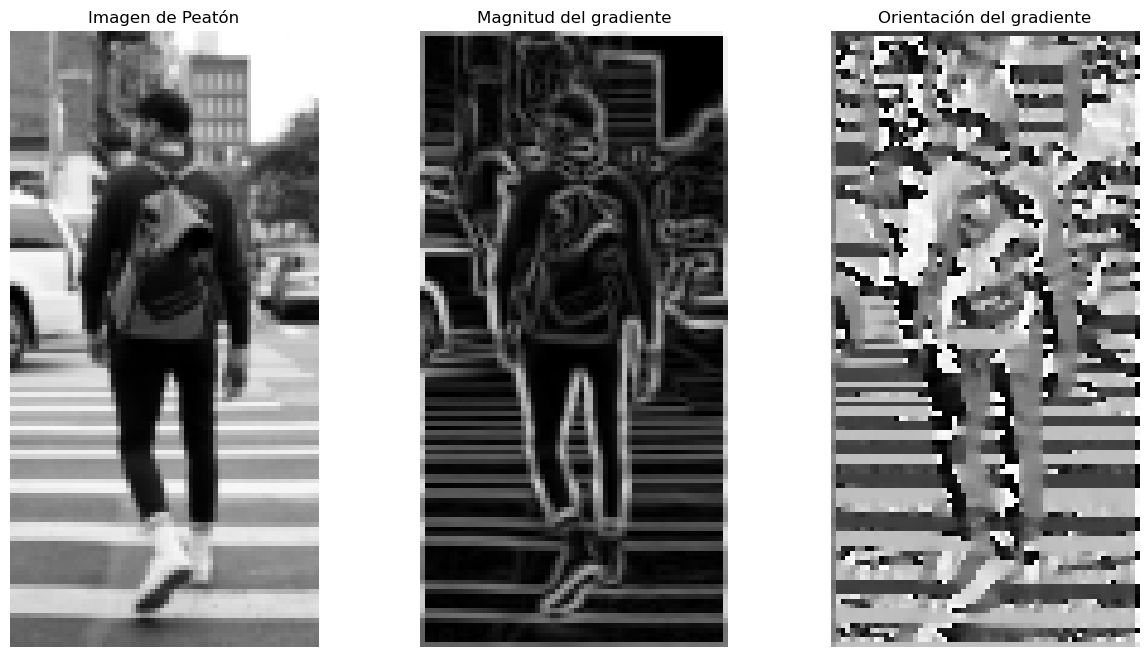

In [14]:
from skimage.io import imread
from scipy.signal import correlate2d
from skimage.transform import resize

img_gray = resize(imread("peaton.png", as_gray=True), (128,64))
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
sobel_y = np.array([[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]])

x_grad = correlate2d(img_gray, sobel_x, mode="same")
y_grad = correlate2d(img_gray, sobel_y, mode="same")
grad_magnitude = (x_grad ** 2 + y_grad ** 2) ** 0.5
grad_direction = np.arctan2(y_grad, x_grad)

plt.figure(figsize=(15,8))

plt.subplot(131)
plt.title("Imagen de Peatón")
plt.imshow(img_gray, cmap="gray")
plt.axis("Off")

plt.subplot(132)
plt.title("Magnitud del gradiente")
plt.imshow(grad_magnitude, cmap="gray")
plt.axis("Off")

plt.subplot(133)
plt.title("Orientación del gradiente")
plt.imshow(grad_direction, cmap="gray")
plt.axis("Off")
plt.show()

Como ruta general, tenga en cuenta que las celdas están conformadas por píxeles, los bloques están conformados por celdas, y la imagen completa está conformada por bloques que se sobrelapan. La siguiente imagen puede ayudar a su comprensión:

<div>
<img src="hog.png" width="450"/>
</div>


A continuación haremos un análisis detallado de las dimensiones de cada componente del algoritmo.

Dividiremos la imagen en celdas de tamaño de 8 x 8 píxeles. Nuestra imagen es de 128 x 64 píxeles. Esto implica que habrán 16 x 8 = 128 celdas. A continuación, implementaremos una función que calcula el histograma de gradientes orientados para una celda a partir de considerar 9 orientaciones distintas (una orientación cada 20 grados entre los 0 y 180 grados; se considera que orientaciones antiparalelas son equivalentes):

In [15]:
def HOG_cell(grad_magnitude, grad_direction):
    # Se linealiza la ventana de magnitud de gradiente. A los valores negativos se les suma 180 para considerar
    # orientaciones antiparalelas como iguales
    grad_magnitude = grad_magnitude.flatten()
    grad_direction[grad_direction < 0] += 180
    # Se linealiza la ventana de dirección de gradiente.
    grad_direction = grad_direction.flatten()
    # Se inicializa el histograma como un vector de 0s de longitud 9, igual a la cantidad de orientaciones distintas a
    # considerar
    hog = np.zeros((1, 9))
    
    # Para cada píxel de la ventana:
    for i in range(len(grad_magnitude)):
        # El bin asociado a la orientación del gradiente se calcula mediante la parte entera resultante de dividir el
        # ángulo entre 20. Por ejemplo: 30 / 20 = 1.5 -> El ángulo 30 pertenece al bin de índice 1.
        angle_bin = int(grad_direction[i] // 20)
        # Sumamos la magnitud del gradiente al bin correspondiente en el histograma
        hog[0, angle_bin] += grad_magnitude[i]
    
    # Retornamos el histograma de gradientes orientados de la ventana.
    return hog

Para obtener un descriptor local más completo, se crean bloques de 2 x 2 celdas. Para cada bloque, se obtiene un descriptor resultante de concatenar los HOG de las 4 celdas que lo compone. Esto quiere decir que el descriptor de cada bloque tiene 9 x 4 = 36 entradas. Los bloques adyacentes se sobrelapan en 2 celdas. Esto implica que para una imagen de 128 x 64 píxeles (16 x 8 celdas), se obtienen 15 x 7 = 105 bloques.

A continuación implementaremos una función que obtiene el descriptor de un bloque:

In [16]:
def HOG_block(grad_magnitude, grad_direction, pix_per_cell):
    # Se crea lista vacía en la que se irán agragando los HOG de cada bloque
    hog_block = []
    #Para cada celda del bloque:
    for i in range(grad_magnitude.shape[0] // pix_per_cell):
        for j in range(grad_magnitude.shape[1] // pix_per_cell):
            cell_grad_mag = grad_magnitude[i * pix_per_cell : (i+1) * pix_per_cell, j * pix_per_cell : (j+1)* pix_per_cell]
            cell_grad_dir = grad_direction[i * pix_per_cell : (i+1) * pix_per_cell, j * pix_per_cell : (j+1)* pix_per_cell]
            # El HOG de cada celda se agrega a la lista
            hog_block.append(HOG_cell(cell_grad_mag, cell_grad_dir))
    # Se concatenan los HOG de todas las celdas en un solo vector fila de numpy
    hog_block = np.hstack(hog_block)
    return hog_block

mock_block = np.eye(16)
hog_block = HOG_block(mock_block, mock_block, pix_per_cell=8)
print("Las dimensiones del descriptor de un bloque de 16 x 16 píxeles, cuando cada celda es de 8 x 8 píxeles, es:", hog_block.shape)

Las dimensiones del descriptor de un bloque de 16 x 16 píxeles, cuando cada celda es de 8 x 8 píxeles, es: (1, 36)


Para obtener una representación completa de la imagen se concatenan los descriptores de cada bloque. Si hay 105 bloques, y el descriptor de cada bloque tiene 36 entradas, el descriptor de la imagen completa tiene 105 x 36 = 3780 entradas. A continuación, se implementa una función que calcula el descriptor de HOG de una imagen a partir del tamaño de sus celdas y bloques, asumiendo que estos son cuadrados:

In [17]:
def HOG_image(img, pix_per_cell, cell_per_block):
    
    # Se calcula el lado de un bloque en pixeles
    pix_per_block = pix_per_cell * cell_per_block
    
    # Se calculan los mapas de magnitud y dirección del gradiente
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]])

    x_grad = correlate2d(img, sobel_x, mode="same")
    y_grad = correlate2d(img, sobel_y, mode="same")
    
    grad_magnitude = (x_grad ** 2 + y_grad ** 2) ** 0.5
    grad_direction = np.arctan2(y_grad, x_grad)
    
    # Se crea lista vacía en la que se irán agragando los HOG de cada bloque
    hog_img = []
    
    #Para cada bloque:
    # for i in range(0, 15)

    for i in range(img.shape[0] // pix_per_cell - (cell_per_block-1)):
        # for i in range(0, 15)
        for j in range(img.shape[1] // pix_per_cell - (cell_per_block-1)):
            
            block_grad_mag = grad_magnitude[i * pix_per_cell: i * pix_per_cell + pix_per_block,
                                            j * pix_per_cell: j * pix_per_cell + pix_per_block]
            block_grad_dir = grad_direction[i * pix_per_cell: i * pix_per_cell + pix_per_block,
                                            j * pix_per_cell: j * pix_per_cell + pix_per_block]
            # El HOG de cada celda se agrega a la lista
            hog_img.append(HOG_block(block_grad_mag, block_grad_dir, pix_per_cell))

    # Se concatenan los HOG de todos los bloques en un solo vector fila de numpy
    hog_img = np.hstack(hog_img)

    return hog_img

HOG_img = HOG_image(img_gray, pix_per_cell=8, cell_per_block=2)
print("Las dimensiones del descriptor de HOG de toda la imagen son: ", HOG_img.shape)    

Las dimensiones del descriptor de HOG de toda la imagen son:  (1, 3780)


Alternativamente, utilizando la función `hog` de la librería `skimage.feature` podemos obtener el descriptor y una visualización de la distribución de gradientes por celdas, tal como se muestra a continuación. Note que las dimensiones del descriptor obtenido mediante la librería con los parámetros propuestos previamente coincide con las obtenidas en la implementación manual.

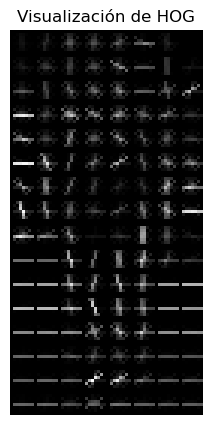

Las dimensiones del descriptor de HOG de la imagen son:  (3780,)


In [18]:
from skimage.feature import hog

fd, hog_image = hog(img_gray, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)

plt.figure(figsize=(12,5))
plt.title("Visualización de HOG")
plt.imshow(hog_image, cmap="gray")
plt.axis("off")
plt.show()

print("Las dimensiones del descriptor de HOG de la imagen son: ", fd.shape)

### Ejercicio 2:
Por otro lado, SIFT es un algoritmo similar a HOG, donde el descriptor es más especifico a ventanas sobre cada pixel. El algoritmo es el siguiente.

>- Seleccionar una ventana 16×16 alrededor de cada píxel y dividirla en celdas de 4×4.
>- Calcular el histograma de gradiente orientado HOG (con 8 ángulos de referencia) para todas las celdas (de 4×4).
>- Descriptor resultante 4×4×8=128 dimensiones (para cada píxel).

Ahora, vamos a implementar SIFT usando nuestra función HOG de skimage.feature. Cree una función que entre por parametro una imagen. Esta función debe recorrer los pixeles, crear una ventana 16x16 al rededor, dividir esta ventana en celdas 4x4 sobre las cuales se calcula Hog en 8 orientaciones y se concatenan todos los descriptores al final.

**Nota:** Use un padding de 0s.

In [19]:
def SIFT(Im):
    # YOUR CODE HERE
    m, n = Im.shape
    descriptor = []
    pad_Im = np.pad(Im, ((8, 8), (8, 8)), mode='constant', constant_values=0)

    # se recorre cada pixel de la imagen
    for i in range(m):
        for j in range(n):
            # se crea la ventana de cada pixel
            window = pad_Im[i:i+16, j:j+16]
            # se hace hog a la ventana
            hog_window = hog(window, orientations=8, pixels_per_cell=(4,4), cells_per_block=(4,4))
            # se agrega el HOG de la ventana del pixel a la respuesta
            descriptor.extend(hog_window)

    descriptor = np.array(descriptor)    
    return descriptor

In [20]:
descriptor=SIFT(img_gray)

assert len(descriptor)==img_gray.shape[0]*img_gray.shape[1]*8*4*4, 'El descriptor de un solo pixel debe ser 128, 8 orientaciones por 16 celdas por la cantidad de pixels de la imagen'
assert np.sum(np.std(descriptor.reshape((img_gray.shape[0]*img_gray.shape[1],128,)),0))>0.01, f'Usted concatenó el descriptor de un solo pixel varias veces'
assert np.isclose(np.sum(descriptor),48880.565,0.01), f'Usted calculó mal el descriptor, la no suma debería ser {np.sum(descriptor)}'

## Atención!!!
Este tutorial debe estar completo, no se calculará los puntos parciales.

## Créditos
### Realizado por:
Danniel Moreno- Santiago Usma
### Supervisado por:
Felipe Escallón Páez - Jose Miguel Abril Nova

2023